In [1]:
using GeometricIntegrators
using Gadfly

In [2]:
s  = 3
np = 101

101

## Define Lagrange Polynomial

In [3]:
struct LagrangePolynomial{T<:AbstractFloat}
    p::Int
    n::Int
    x::Vector{T}
    y::Vector{T}
    denom::Vector{T}
    
    function LagrangePolynomial{T}(x, y) where {T}
        local p::T

        @assert length(x) == length(y)
        
        denom = zeros(length(x))
    
        for i in 1:length(x)
            p = one(T)
            for j in 1:length(x)
                if i ≠ j
                    p *= (x[i] - x[j])
                end
            end
            denom[i] = 1/p
        end
        
        new(length(x)-1, length(x), x, y, denom)
    end
end

function LagrangePolynomial(x::Vector{T}, y::Vector{T}) where {T}
    LagrangePolynomial{T}(x, y)
end

LagrangePolynomial

In [4]:
function evaluate!(pol::LagrangePolynomial{T}, sy::Vector{T}, x::Vector{T}, y::Vector{T}) where {T}
    @assert length(sy) == pol.n
    @assert length(x) == length(y)
    
    local p::T
    local tx::T
    local ty::T

    for k in 1:length(x)
        tx = x[k]
        ty = 0
        for j in 1:pol.n
            p = 1
            for i in 1:pol.n
                if i ≠ j
                    p *= (tx - pol.x[i])
                end
            end
            ty += p * sy[j] * pol.denom[j]
        end
        y[k] = ty
    end
        
    return nothing
end

evaluate! (generic function with 1 method)

In [5]:
function evaluate!(pol::LagrangePolynomial{T}, x::Vector{T}, y::Vector{T}) where {T}
    evaluate(pol, pol.y, x, y)
end

evaluate! (generic function with 2 methods)

## Define Inverse Vandermonde Matrix

In [6]:
function vandermonde_matrix_inverse(pol::LagrangePolynomial{T}) where {T}
    local L::Matrix{T} = zeros(pol.n, pol.n)
    local U::Matrix{T} = eye(pol.n)
    local V::Matrix{T}
    
    L[1,1] = 1
    for i in 2:pol.n
        for j in 1:i
            p = 1
            for k in 1:i
                if k ≠ j
                    p *= (pol.x[j] - pol.x[k])
                end
            end
            L[i,j] = 1/p
        end
    end

    i = 1
    for j in i+1:pol.n
        U[i,j] = - U[i,j-1] * pol.x[j-1]
    end

    for i in 2:pol.n
        for j in i+1:pol.n
            U[i,j] = U[i-1,j-1] - U[i,j-1] * pol.x[j-1]
        end
    end

    V = *(U,L)
end

vandermonde_matrix_inverse (generic function with 1 method)

## Obtain Gauss-Legendre Quadrature Points and Weights

In [7]:
using FastGaussQuadrature

In [8]:
gl = gausslegendre(s)

([-0.774597, 0.0, 0.774597], [0.555556, 0.888889, 0.555556])

In [9]:
c = (gl[1]+1)/2

3-element Array{Float64,1}:
 0.112702
 0.5     
 0.887298

In [10]:
b = gl[2]/2

3-element Array{Float64,1}:
 0.277778
 0.444444
 0.277778

## Define Lagrange Polynomial

In [11]:
lag = LagrangePolynomial(c, ones(s))

LagrangePolynomial{Float64}(2, 3, [0.112702, 0.5, 0.887298], [1.0, 1.0, 1.0], [3.33333, -6.66667, 3.33333])

In [12]:
xp = collect(linspace(0., 1., np));

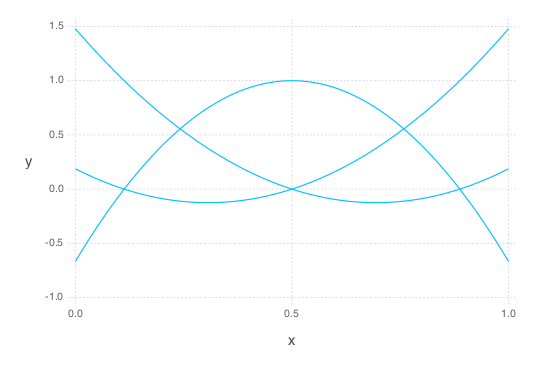

In [13]:
layers = []

for i in 1:s
    y = zeros(s)
    y[i] = 1
    yp = zeros(np)
    evaluate!(lag, y, xp, yp)
    push!(layers, layer(x=xp, y=yp, Geom.line))
end

plot(layers...)

## Determine Monomial Form of Lagrange Basis

In [14]:
using Polynomials

In [15]:
function evaluate!(pol::Poly{T}, x::Vector{T}, y::Vector{T}) where {T}
    @assert length(x) == length(y)
    
    for j in 1:length(y)
        y[j] = pol(x[j])
    end
end

evaluate! (generic function with 3 methods)

In [16]:
vdm_inv = vandermonde_matrix_inverse(lag)

3×3 Array{Float64,2}:
  1.47883  -0.666667   0.187836
 -4.62433   6.66667   -2.04234 
  3.33333  -6.66667    3.33333 

In [17]:
polys = []

for i in 1:s
    y = zeros(s)
    y[i] = 1
    mon = *(vdm_inv, y)
    push!(polys, Poly(mon))
end

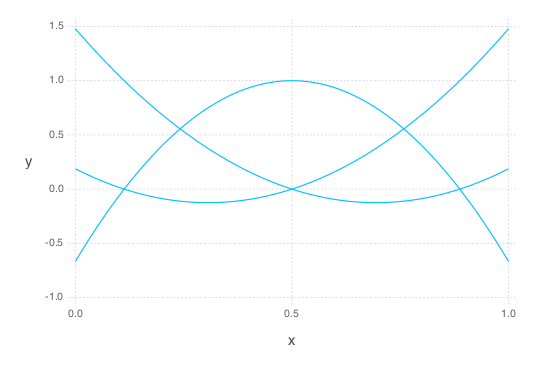

In [18]:
layers = []

for i in 1:s
    yp = zeros(np)
    evaluate!(polys[i], xp, yp)
    push!(layers, layer(x=xp, y=yp, Geom.line))
end

plot(layers...)

## Determine Integral of Lagrange Basis Functions

In [19]:
poly_ints = []

for i in 1:s
    push!(poly_ints, polyint(polys[i]))
end

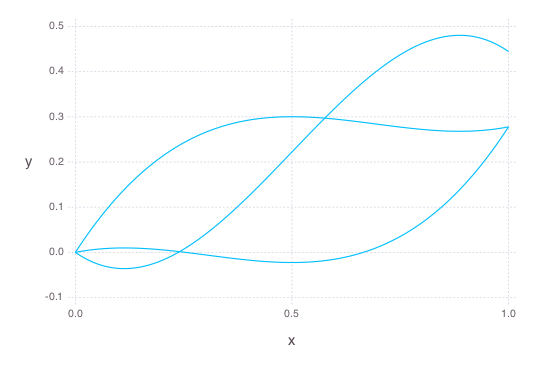

In [20]:
layers = []

for i in 1:s
    yp = zeros(np)
    evaluate!(poly_ints[i], xp, yp)
    push!(layers, layer(x=xp, y=yp, Geom.line))
end

plot(layers...)

## Compute Runge-Kutta Coefficients

In [21]:
A = zeros(s,s)

3×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [22]:
for i in 1:s
    for j in 1:s
        A[i,j] = poly_ints[j](c[i])
    end
end

In [23]:
A

3×3 Array{Float64,2}:
 0.138889  -0.0359767   0.00978944
 0.300263   0.222222   -0.0224854 
 0.267988   0.480421    0.138889  

## Compare with Reference

In [24]:
using Base.Test

In [25]:
ref = getTableauGLRK(s).q

Runge-Kutta Coefficients GLRK3 with 3 stages and order 6  a = [0.138889 -0.0359767 0.00978944; 0.300263 0.222222 -0.0224854; 0.267988 0.480421 0.138889]  b = [0.277778, 0.444444, 0.277778]  c = [0.112702, 0.5, 0.887298]

In [26]:
ref_eps = 1E-15

1.0e-15

In [27]:
@test A ≈ ref.a atol=ref_eps
@test b ≈ ref.b atol=ref_eps
@test c ≈ ref.c atol=ref_eps

Test Passed

In [28]:
ref.a - A

3×3 Array{Float64,2}:
 0.0          -1.38778e-17  1.73472e-18
 5.55112e-17  -1.11022e-16  3.1225e-17 
 4.44089e-16  -1.66533e-16  1.66533e-16